# Modelo SIR Utilizando python

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from IPython.display import display, Math, Latex, clear_output

from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
from scipy import stats as sps
from scipy.interpolate import interp1d

* Es uno de los modelos epidemiológicos más simples capaces de capturar muchas de las características típicas de los brotes epidémicos.
* Describe la transmisión de una enfermedad en una población. La población de N individuos se divide en 3.
* S(t): Población susceptible a enfermar. Aún no han sufrido la infección, pero pueden sufrirla.
* I(t): Población infectada. Es aquella que está pasando por la infección.
* R(t): Población que se ha recuperado de la infección y ahora dispone de inmunidad o ha fallecido tras pasar por la infección
* Beta: Es la tasa de transmisión (indica cómo de sensillo o complicado un miembro de la población I infecte a un miembro de la población S) (Se mide en términos de probabilidad)
* Gamma: Es la tasa de recuperación (indica cómo de sensillo o complicado un miembro de la población I se recupera) (se mide en términos de probabilidad)

### Sistema de ecuaciones diferenciales utilizado en el modelo

In [2]:
display(Math(r' \frac{dS}{dt}=-\frac{\beta \cdot S \cdot I}{N}'))
display(Math(r' \frac{dI}{dt}=\frac{\beta \cdot S \cdot I}{N}-\gamma \cdot I'))
display(Math(r' \frac{dR}{dt}=\gamma \cdot I'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Tasa básica de reproducción

* En este caso, modelar I(t) permite analizar como evolucina la enfermedad
* Modelando I(t), se puede observar que su valor depende de la relación existente entre beta y gamma
* Esta relación se conoce como tasa básica de reproducción R0

In [3]:
display(Math(r' \frac{dI}{dt}=\frac{\beta \cdot S \cdot I}{N}-\gamma \cdot I'))
display(Math(r' Supociciones: S>>>I ; S = N'))
display(Math(r' \frac{dI}{dt}=(\beta - \gamma) \cdot I'))
display(Math(r' I(t)=I_0 \cdot e^{(\beta-\gamma)\cdot t}'))
display(Math(r' e^{(\frac{\beta}{\gamma}-\frac{\gamma}{\gamma})\cdot t}'))
display(Math(r' R_0=\frac{\beta}{\gamma}>1 --->I(t) aumenta'))
display(Math(r' R_0=\frac{\beta}{\gamma}<1 --->I(t) disminuye'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Aplicación del modelo a los datos de España

In [4]:
#Definir el path donde se encuentra el dataset con los datos de confirmados
path1="Dataset\\COVID-19-master\\csse_covid_19_data\\csse_covid_19_time_series\\time_series_covid19_confirmed_global.csv"

In [5]:
data_confirmed=pd.read_csv(path1)


In [6]:
Data_Confirmed_Spain=data_confirmed[data_confirmed["Country/Region"]=="Spain"]

In [7]:
Data_Confirmed_Spain.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20
226,NaN,Spain,40.463667,-3.74922,0,0,0,0,0,0,...,342813,359082,364196,370867,377906,386054,386054,386054,405436,412553


In [8]:
#Lista con valores de fecha (evadiendolas 4 primeras filas)
date_value_list=data_confirmed.columns.values.tolist()
date_value=date_value_list[4:]
#Lista de confirmados
confirmed_value=Data_Confirmed_Spain.iloc[0,4:].tolist()
(len(date_value),len(confirmed_value))

(217, 217)

In [9]:
#Preparación del DataFrame
Spain_Data=pd.DataFrame({
    "Fecha":date_value,
    "Total Confirmados":confirmed_value,
})

In [10]:
#Convertir la fecha en formato Date
Spain_Data["Fecha"]=pd.to_datetime(Spain_Data["Fecha"])


In [11]:
#Obtener el número de infectados diarios
Spain_Data=Spain_Data.diff()
#Eliminación de los valores negativos 
Spain_Data[Spain_Data['Total Confirmados']<0]=0

In [12]:
Spain_Data[Spain_Data['Total Confirmados']<0]

,Fecha,Total Confirmados


In [13]:
Spain_Data.head()

,Fecha,Total Confirmados
0,NaT,NaN
1,1 days 00:00:00,0.0
2,1 days 00:00:00,0.0
3,1 days 00:00:00,0.0
4,1 days 00:00:00,0.0


In [14]:
#Condiciones iniciales
#Condiciones en las que t=0
#Población España
N=47000000
#Número inicial de población infectada
I0=100
#Recuperados en el tiempo t=0
R0=0
#Población susceptible inicial
S0=N-I0-R0
#Valores medios estimados de beta y gamma
beta=0.1
gamma=0.035
t=np.linspace(0,175,175)
y0=S0,I0,R0

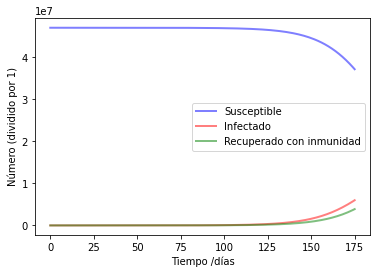

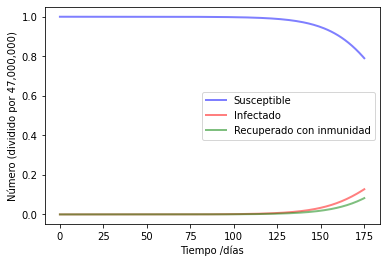

In [15]:
#Definición de las ecuaciones diferenciales
#y es una lista con los datos de S,I,R
def SIR_dev(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma* I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

#Representasión de los datos
def plot(S, I, R, t, divide_by=1):
    # Dibujamos los datos de S(t), I(t) y R(t)
    fig, ax = plt.subplots()
    ax.plot(t, S / divide_by, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(t, I / divide_by, 'r', alpha=0.5, lw=2, label='Infectado')
    ax.plot(t, R / divide_by, 'g', alpha=0.5, lw=2, label='Recuperado con inmunidad')
    ax.set_xlabel('Tiempo /días')
    ax.set_ylabel(f'Número (dividido por {divide_by:,})')
    legend = ax.legend()

# Se le pasa el sistema de ecuaciones diferenciales, las condiciones iniciales, los puntos donde resolver el sistema de
#ecuaciones diferenciales y las condiciones que definen el sistema
ret = odeint(SIR_dev, y0, t, args=(N, beta, gamma))
S, I, R = ret.T
 
plot(S, I, R, t) # Datos sin normalizar
plot(S, I, R, t, divide_by=N) # Datos normalizados

In [16]:
#Con un valor de R0 de 2.85 y una población infectada inicial de 100
#A los 175 días se observa que:
#La población susceptible a las 175 días es:
print('Población susceptible a los 175 días: ',round(S[len(S)-1],2))
#Población que se ha recuperado de la enfermedad en los 175 días
print('Población que se ha recuperado en los 175 días: ',round(R[len(R)-1],2))
#La población infectada a los 175 días es:
print('Población que Infectada en los 175 días: ',round(I[len(I)-1],2))

Población susceptible a los 175 días:  37135902.92
Población que se ha recuperado en los 175 días:  3874982.37
Población que Infectada en los 175 días:  5989114.71


* Como ya se ha comentado, R0 es una variable estática, por lo que no puede utilizarce para modelar el comportamiento o la evolución de la pandemia.
* Esto se debe principalmente a los continuos cambios de las condiciones que afectan a la propagación del virus
* Por este motivo se precisa del uso de otro parámetro, que si permite reflejar y controlar la situación real respecto a la evolución de la enfermedad.
* Los valores obtenidos en el modelo SIR no difieren de forma significativa de los valores reales. No obstante R0 es fija, y se ha estimado un valor medio de este. Factor que hace que este modelo no sea el más apropiado para los objetivos del proyecto (modelar la evolución de la pandemia, facilitando la toma de decisiones)

## Cálculo de Rt

* Debido a que R0 en el modelo SIR es un parámetro constante. se conoce o se supone el valor de R0 desde el día t=0, con n número de personas infectadas. Las n personas infectadas, afectan a la población susceptible en términos constantes. Con el valor de R0, no se puede analizar el efecto que producen los cambios en las condiciones que afectan a la evolución de la enfermedad. Por lo tanto se necesita que este parámetro sea diario. Por este motivo de utiliza Rt
* No obstante, es necesario tener cuenta que modelar la evolución de una enfermeda con el parámetro Rt, tiene mayor eficiencia cuando se trata de grupos pequeños localizados. Ejemplo: Rt(bloque piso)>Rt(barrio)>Rt(pueblo)>Rt(Ciudad)>Rt(País). La dificultad radica en la difícultad de encontrar datos registrados respecto a las decisiones tomadas en los niveles más pequeños.En esta ocación, se aplicará al nivel (país), ya que se disponen de los datos de las decisiones tomadas. 
* El valor de Rt que se obtiene en este estudio es el correspondiente a cudades en la primera hola.

### Teorema de bayes

* Ai=Conjunto de sucesos
* B=Suceso cualquiera del espacio muestral
* Conociendo que se cumple el suceso B, se quiere conocer la probabilidad de que la causa de el suceso B sea que haya sucedido el suceso Aj
* Distribución gaussiana concentrada en $ R_{t-1}$

In [17]:
display(Math(r'P(A_j|B)= \frac{P(A_j)P(B|A_j)}{\sum_{i=1}^nP(A_i)P(B|A_i)}'))
display(Math(r'P(R_t|k)= \frac{P(R_t)P(k|R_t)}{\sum_{i=1}^nP(R_t(i))P(k|R_t(i))}'))
display(Math(r'P(R_t|R_{t-1}) = N(R_{t-1}| \sigma)'))
display(Math(r'P(R_1|k_1) \alpha P(R_1) \cdot L(R_1|k_1)'))
display(Math(r'P(R_2|k_1,k_2) \alpha P(R_2) \cdot L(R_2|k_2)= \sum_{R_t}P(R_1|k_1) \cdot P(R_2|k_2)\cdot L(R_2|k_2)'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

* Distribución de probabilidades de la función P(K|Rt)
* Se toma la distribución de poisson
* Dicha función de probabilidad establece cómo de probable existirán k nuevos casos en función del valor de Rt
* Dada una tasa de llegada promedio lambda por día, la probabilidad de ver k casos nuevos se distribuye de acuerdo con la distribución de poisson

In [18]:
display(Math(r'P(k|\lambda)= \frac{\lambda^k\cdot e^{-\lambda}}{k!}'))

<IPython.core.display.Math object>

* Distribución de probabilidad de una variable aleatoria discreta, que proporciona la probabilidad de que ocurra un suceso un número de veces k en un intervalo determinado de tiempo, longitud,área
* $\lambda$= nº de veces que ocurre nuestro suceso en el intervalo de tiempo, longitud, superficie
* Se trabaja con k número de casos en un intervalo de tiempo establecido
* Sabiendo el número de casos por día, se obtiene el valor de $R_t$ más probable. Para realizar esta acción, se ajusta k, mientras se varía lambda. A esto se le llama función de verosimilitud.
* Relación existente entre $\lambda$ y $R_t$ (Mapeo de $R_t$ respecto de $\lambda$)

In [19]:
display(Math(r'\lambda= k_{t-1}\cdot e^{\gamma \cdot (R_t-1)}'))
display(Math(r'P(k|\lambda)= \frac{\lambda^k\cdot e^{-\lambda}}{k!}'))
display(Math(r'P(k|\lambda)= \frac{k_{t-1}\cdot e^{\gamma \cdot (R_t-1)-\lambda}}{k!}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

* $\gamma$=intervalo de la serie (7 días) -->1/7
* Se evaluará la probabilidad en cada día y se normalizará la suma cada día a 1
* Se aplica un filtro gaussiano en la serie temporal

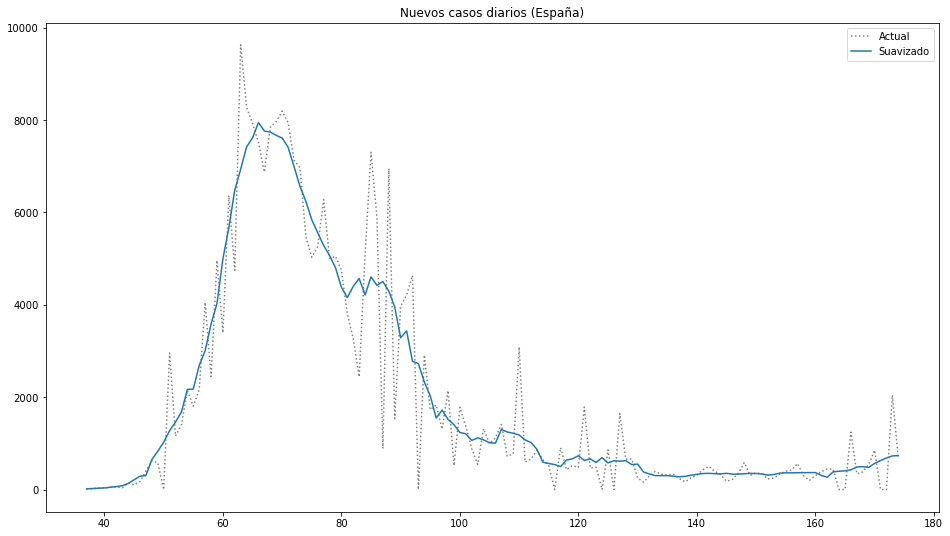

In [20]:
def prepare_cases(cases, cutoff=15):
    
    new_cases=cases
    #Suavizamiento de los datos
    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=4).round()
    
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = Spain_Data['Total Confirmados'][1:175]

original, smoothed = prepare_cases(cases)

original.plot(title="Nuevos casos diarios (España)",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(16, 9))

ax = smoothed.plot(label='Suavizado',
                   legend=True)

ax.get_figure().set_facecolor('w')

In [21]:
def get_posteriors(sr, sigma=0.15):
    #Periodo de 7 días
    GAMMA = 1/7
    
    #Valor máximo de Rt, rango rt
    R_T_MAX = 12
    r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

    # (1) Cálculo  de lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Cálculo de la probabilidad de cada día
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3)Creación de la matriz gaussiana
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalización de los datos en tanto por 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) cálculo del initial prior
    #prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 = np.ones_like(r_t_range)/len(r_t_range)
    prior0 /= prior0.sum()

    # Creación de un DataFrame que mantendrá los posteriors para cada día
    # Se incerta el prior obtenido antes del primer dato posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # Seguimiento de la suma del logaritmo de la probabilidad
    # para los dato, en el cálculo de máxima verosimilitud
    log_likelihood = 0.0

    # (5) Aplicar iterativamente la regla de Bayes
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calcular el nuevo prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calcular el numerador de la ley de Bayes' P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcular el denominador de la ley de Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # ley de bayes al completo
        posteriors[current_day] = numerator/denominator
        
        # Agregar a la suma acumulada de probabilidades de registro
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

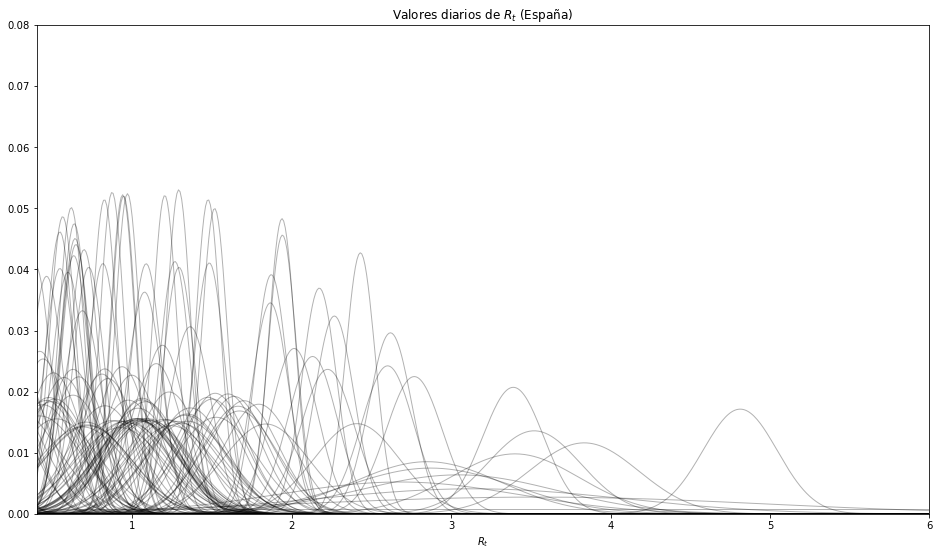

In [22]:
ax = posteriors.plot(title='Valores diarios de $R_t$ (España)' ,
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,6),
            figsize=(16, 9))

plt.ylim(0, 0.08)
ax.set_xlabel('$R_t$');

* Necesario incluir Intervalos de confianza, ya que Rt son probabilidades calculadas en función de los nuevos casos 

In [23]:
most_likely = posteriors.idxmax().rename('ML')
most_likely

37     0.00
38     3.54
39     3.14
40     2.68
41     3.05
       ... 
170    1.66
171    1.70
172    1.64
173    1.52
174    1.23
Name: ML, Length: 138, dtype: float64

In [24]:
Spain_Data=pd.DataFrame({
    "Fecha":date_value,
    "Total Confirmados":confirmed_value,
})
Spain_Data["Fecha"]=pd.to_datetime(Spain_Data["Fecha"])

In [25]:
len(most_likely)

138

In [26]:
xDate=Spain_Data["Fecha"][37:175]
len(xDate)

138

In [27]:
Dic_Desiciones_España=pd.DataFrame({
    "Fecha":["14-03-2020","29-03-2020","21-04-2020","23-05-2020","26-05-2020","21-06-2020","07-07-2020"],
    "Siglas_Desición":["EA","CTNE","SMC","CTF","IDes","NN","EV_SpC"],
    "Significado":["Estado Alarma","Confinamiento Trabajadores No Esenciales",
    "Salida de menores de 14","Cierre Total Frontera","Inicio Desescalada",
    "Nueva Normalidad","Entrada de viajeros sin posibilidad de cuarentena"]
})


In [28]:
Dic_Desiciones_España["Fecha"]=pd.to_datetime(Dic_Desiciones_España["Fecha"])

In [29]:
Dic_Desiciones_España.dtypes

Fecha              datetime64[ns]
Siglas_Desición            object
Significado                object
dtype: object

In [30]:
num=np.ones(len(Dic_Desiciones_España["Fecha"]))

In [31]:
Dic_Desiciones_España

,Fecha,Siglas_Desición,Significado
0,2020-03-14,EA,Estado Alarma
1,2020-03-29,CTNE,Confinamiento Trabajadores No Esenciales
2,2020-04-21,SMC,Salida de menores de 14
3,2020-05-23,CTF,Cierre Total Frontera
4,2020-05-26,IDes,Inicio Desescalada
5,2020-06-21,NN,Nueva Normalidad
6,2020-07-07,EV_SpC,Entrada de viajeros sin posibilidad de cuarentena


In [36]:
#Carga los datos de nuevo, para realizar las representaciones necesarias
Spain_Data=pd.DataFrame({
    "Fecha":date_value,
    "Total Confirmados":confirmed_value,
})

In [38]:
#Convertir la fecha en formato Date
Spain_Data["Fecha"]=pd.to_datetime(Spain_Data["Fecha"])

In [39]:
x=Spain_Data["Fecha"][37:175]

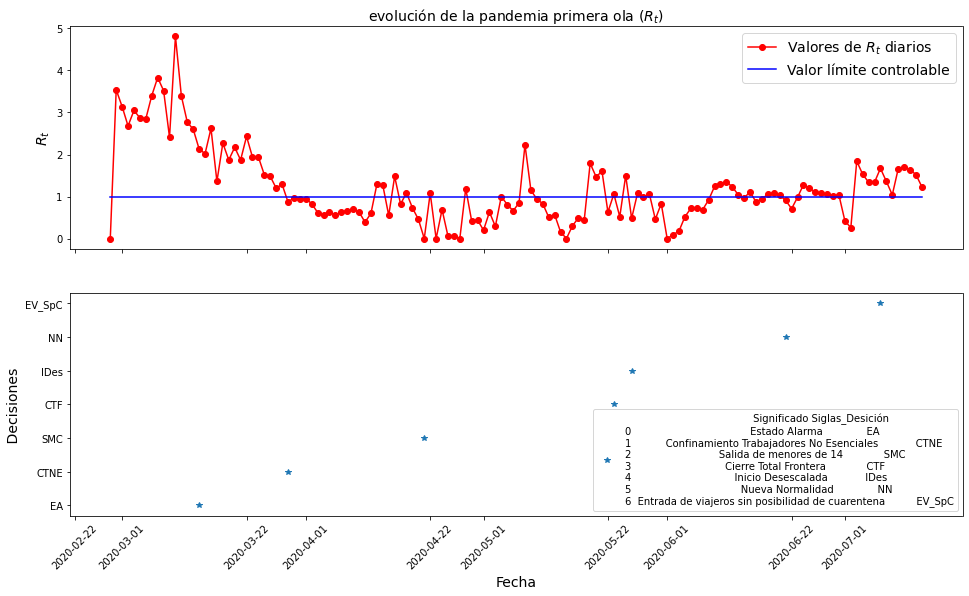

In [51]:
xd=Dic_Desiciones_España["Fecha"]
#x=np.arange(37,175,1)
x=Spain_Data["Fecha"][37:175]

yd=Dic_Desiciones_España["Siglas_Desición"]
y=most_likely
ylimit=np.ones(len(x))

c=Dic_Desiciones_España[["Significado","Siglas_Desición"]]

fig, (ax1,ax2)=plt.subplots(2,1,sharex=True, figsize=(16,9))
ax1.plot(x,y,'-o',color='r',label='Valores de $R_t$ diarios')
ax1.plot(x,ylimit,color='blue',label='Valor límite controlable')
ax1.set_ylabel("$R_t$").set_fontsize(14)
ax1.set_title("evolución de la pandemia primera ola ($R_t$)").set_fontsize(14)
ax2.plot(xd, yd,'*', label=c)
ax2.set_xlabel("Fecha").set_fontsize(14)
ax2.set_ylabel(" Decisiones ").set_fontsize(14)
plt.xticks(rotation=45)
ax1.legend(prop={"size":14})
ax2.legend(loc='lower right')